# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs,\
                scheduler_step=1, lr_decay_factor=1, floor_lr=0.01, roof_lr=0.01):
    if floor_lr != roof_lr:
        # cyclical learning rate
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=floor_lr, max_lr=roof_lr)
    else:
        # Learning rate annealing
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=lr_decay_factor)
    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        prediction = model(x)    
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.809839, Train accuracy: 0.422107, Val accuracy: 0.545151
Average loss: 1.449709, Train accuracy: 0.586800, Val accuracy: 0.600573
Average loss: 1.373610, Train accuracy: 0.621029, Val accuracy: 0.603781


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# предлагаемый размер второго hidden layer приводит к overfitting

Average loss: 2.157811, Train accuracy: 0.209040, Val accuracy: 0.237322
Average loss: 1.962926, Train accuracy: 0.292615, Val accuracy: 0.341683
Average loss: 1.797577, Train accuracy: 0.377794, Val accuracy: 0.396560
Average loss: 1.712215, Train accuracy: 0.415026, Val accuracy: 0.427957
Average loss: 1.680039, Train accuracy: 0.431577, Val accuracy: 0.425841


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Batch Normalization оверфиттинг не исправляет

Average loss: 1.881887, Train accuracy: 0.399976, Val accuracy: 0.555730
Average loss: 1.470952, Train accuracy: 0.600502, Val accuracy: 0.641867
Average loss: 1.314036, Train accuracy: 0.654165, Val accuracy: 0.678042
Average loss: 1.226290, Train accuracy: 0.678753, Val accuracy: 0.675312
Average loss: 1.167412, Train accuracy: 0.694246, Val accuracy: 0.693195


# Расчет размеров hidden layers

### Пусть даны размеры входных данных, количество определяемых классов и желаемое количество слоев:

```
num_input = 3*32*32

num_output = 10

iterations = 3
```

где `iterations` - это число слоев


### Рассчитываем коэффициент перехода (во сколько раз нужно изменить размер матрицы при переходе с уровня на уровень):

$coef = \left(\frac{num\_output}{num\_input}\right)^{\frac{1}{iterations}}$

### Тогда количество нейронов на i-ом уровне:
$neuro\_num = round\left(num\_input * coef^i\right)$

In [21]:
# замена размеров слоев по описанной формуле исправляет появившуюся проблему overfitting'а

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.838006, Train accuracy: 0.426731, Val accuracy: 0.586786
Average loss: 1.408879, Train accuracy: 0.624492, Val accuracy: 0.665006
Average loss: 1.232936, Train accuracy: 0.677951, Val accuracy: 0.699816
Average loss: 1.129222, Train accuracy: 0.706890, Val accuracy: 0.718995
Average loss: 1.064059, Train accuracy: 0.728867, Val accuracy: 0.728141


Добавьте уменьшение скорости обучения по ходу тренировки.

In [22]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 2, 0.5)

# annealing тоже сам исправлял оверфиттинг, но совместно с такими размерами слоев работает все равно лучше

Average loss: 1.899837, Train accuracy: 0.396973, Val accuracy: 0.568630
Average loss: 1.442208, Train accuracy: 0.617735, Val accuracy: 0.650877
Average loss: 1.249843, Train accuracy: 0.684060, Val accuracy: 0.695447
Average loss: 1.170511, Train accuracy: 0.705269, Val accuracy: 0.722135
Average loss: 1.105157, Train accuracy: 0.730403, Val accuracy: 0.734626


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [23]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         sampler=sampler)
    predictions = np.array([], dtype='int64')
    ground_truth = np.array([], dtype='int64')
    for (x, y) in data_loader:
        prediction = model(x)    
        _, indices = torch.max(prediction, 1)
        predictions = np.append(predictions, indices)
        ground_truth = np.append(ground_truth, y)
    
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

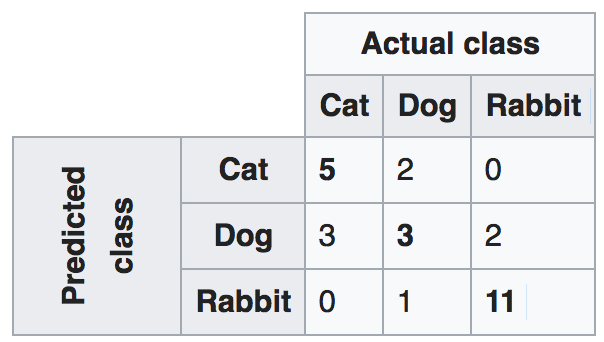

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

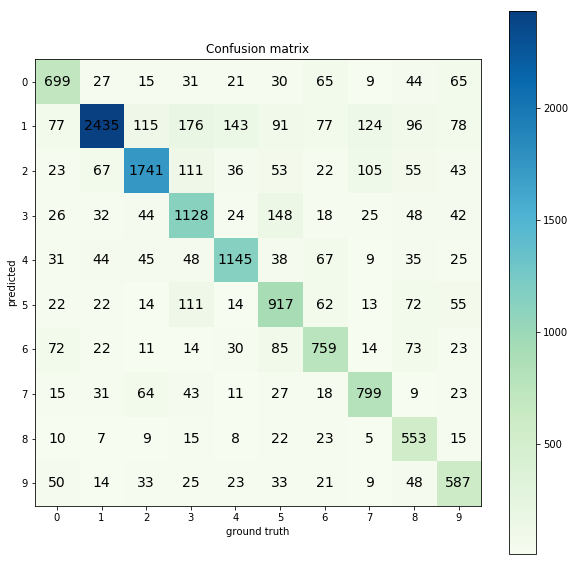

In [24]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for i in np.column_stack((predictions, ground_truth)):
        confusion_matrix[i[0], i[1]] += 1
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

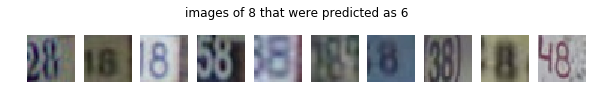

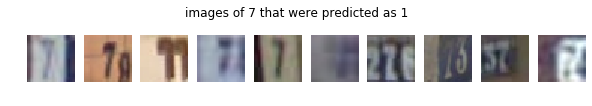

In [25]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(to_show,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    predicted_actual = np.column_stack((predictions, ground_truth))
    selected_indices = val_indices[np.where((predicted_actual == (predicted_class, gt_class)).all(axis=1))[0]]
    visualize_images(selected_indices, data, title='images of %i that were predicted as %i' %(gt_class, predicted_class))

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [33]:
# SGD with momentum

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=0, momentum=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 1, 0.5)

# momentum != 0 дает лучше результат, чем при momentum == 0, но ещё лучше при weight_decay == 0
# т.е. любая оптимизация кроме SGD на данном датасете выигрывает в точности без регуляризации
# по крайней мере в короткой перспективе обучения

Average loss: 1.354554, Train accuracy: 0.577842, Val accuracy: 0.694697
Average loss: 0.882515, Train accuracy: 0.733082, Val accuracy: 0.747184
Average loss: 0.733944, Train accuracy: 0.779289, Val accuracy: 0.785134
Average loss: 0.655974, Train accuracy: 0.803501, Val accuracy: 0.801242
Average loss: 0.614348, Train accuracy: 0.817067, Val accuracy: 0.810047


In [35]:
# Adam optimization instead of SGD

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         )

optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=0)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, 1, 0.5)

# Цитируя одну статью на тему регуляризации и адаптивных оптимизаторов:
# One possible explanation why Adam and other adaptive gradient methods might be outperformed
# by SGD with momentum is that L2 regularization/weight decay are implemented suboptimally in
# common deep learning libraries. Therefore, on tasks/datasets where the use of L2 regularization
# is beneficial (e.g., on many popular image classification datasets), Adam leads to worse results
# than SGD with momentum (for which L2 regularization behaves as expected).

Average loss: 1.333334, Train accuracy: 0.569549, Val accuracy: 0.695857
Average loss: 0.863712, Train accuracy: 0.729516, Val accuracy: 0.750461
Average loss: 0.704375, Train accuracy: 0.780023, Val accuracy: 0.794690
Average loss: 0.614961, Train accuracy: 0.810054, Val accuracy: 0.810730
Average loss: 0.564075, Train accuracy: 0.826502, Val accuracy: 0.816941


In [52]:
# LR range test

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         )

starting_lr = 1e-4
epochs = 15
optimizer = optim.SGD(nn_model.parameters(), lr=starting_lr, momentum=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, epochs, 1, 2)

Average loss: 1.867521, Train accuracy: 0.403013, Val accuracy: 0.575524
Average loss: 1.285154, Train accuracy: 0.632137, Val accuracy: 0.701113
Average loss: 1.020374, Train accuracy: 0.696277, Val accuracy: 0.719064
Average loss: 0.931327, Train accuracy: 0.710081, Val accuracy: 0.720633
Average loss: 0.887844, Train accuracy: 0.721428, Val accuracy: 0.757491
Average loss: 0.851642, Train accuracy: 0.734242, Val accuracy: 0.755034
Average loss: 0.829857, Train accuracy: 0.738371, Val accuracy: 0.753942
Average loss: 0.817145, Train accuracy: 0.742125, Val accuracy: 0.779879
Average loss: 0.821260, Train accuracy: 0.741272, Val accuracy: 0.755170
Average loss: 0.819283, Train accuracy: 0.741733, Val accuracy: 0.755921
Average loss: 0.828901, Train accuracy: 0.738610, Val accuracy: 0.771893
Average loss: 0.891188, Train accuracy: 0.719244, Val accuracy: 0.760494
Average loss: 1.098104, Train accuracy: 0.662628, Val accuracy: 0.699611
Average loss: nan, Train accuracy: 0.167474, Val ac

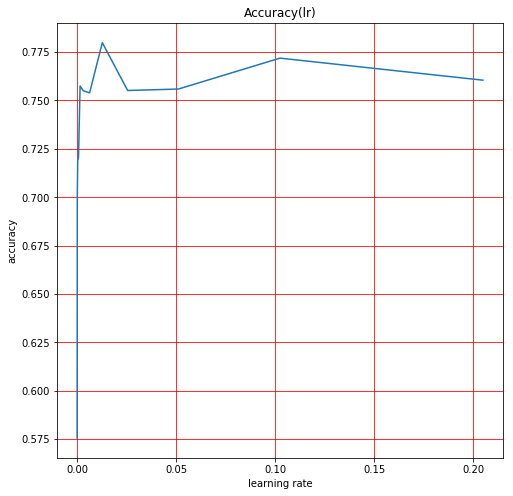

In [58]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy(lr)")
plt.ylabel("accuracy")
plt.xlabel("learning rate")
plt.plot([starting_lr * (2**i) for i in range(12)], val_history[:12])
plt.grid(color='r', linestyle='-')

Average loss: 1.636826, Train accuracy: 0.488585, Val accuracy: 0.658999
Average loss: 1.100048, Train accuracy: 0.678736, Val accuracy: 0.708894
Average loss: 0.916754, Train accuracy: 0.725796, Val accuracy: 0.741383
Average loss: 0.814564, Train accuracy: 0.751937, Val accuracy: 0.776807
Average loss: 0.742939, Train accuracy: 0.772805, Val accuracy: 0.781858
Average loss: 0.690884, Train accuracy: 0.787820, Val accuracy: 0.794826
Average loss: 0.656072, Train accuracy: 0.797325, Val accuracy: 0.777148
Average loss: 0.624350, Train accuracy: 0.805566, Val accuracy: 0.796123


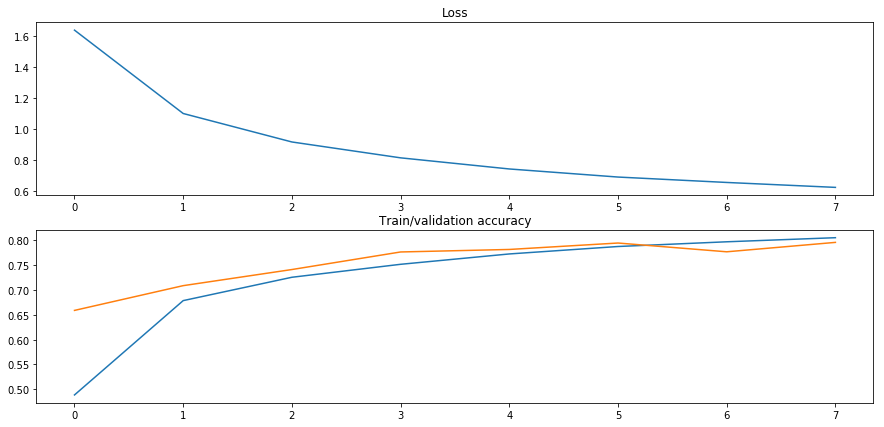

In [59]:
# Cyclical Learning Rate

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 455),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(455),
            nn.Linear(455, 68),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(68),
            nn.Linear(68, 10), 
         ) 

optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, momentum=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8,\
                                                       scheduler_step=1, lr_decay_factor=1, floor_lr=2e-4, roof_lr=1e-1)

plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# просто annealing дает лучше результат быстрее 

In [62]:
num_input = 3*32*32

num_output = 10

iterations = 3


coef = (num_output / num_input) ** (1 / iterations)

neuro_num = []
for i in range(iterations + 1):
    neuro_num.append(round(num_input * coef ** i))
    
neuro_num

[3072, 455, 67, 10]

In [63]:
%%capture

# перебор гиперпараметров с помощью валидационной выборки

best_val_accuracy = None
best_hp = None # hyperparameters

# грубая подборка параметров
for i in range(16):
    # lr, lr_decay_factor, batch_size
    hp = [1/(10**np.random.randint(1, 5)),
          np.random.uniform(low=0.7, high=0.99),
          2**np.random.randint(5, 8)]
    
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=hp[2], sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=hp[2], sampler=val_sampler)
    
    nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(num_input, neuro_num[1]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[1]),
            nn.Linear(neuro_num[1], neuro_num[2]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[2]),
            nn.Linear(neuro_num[2], num_output), 
    )
    
    optimizer = optim.Adam(nn_model.parameters(), lr=hp[0])
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8,\
                                                       scheduler_step=2, lr_decay_factor=hp[1])
    if best_val_accuracy == None:
        best_val_accuracy = val_history[-1]
        best_hp = hp
    elif val_history[-1] > best_val_accuracy:
        best_val_accuracy = val_history[-1]
        best_hp = hp

# coarse to fine по параметру lr
hp = best_hp

train_loader = torch.utils.data.DataLoader(data_train, batch_size=hp[2], sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=hp[2], sampler=val_sampler)

for j in range(8):
    hp[0] *= np.exp(np.random.uniform(low=np.log(1/2), high=np.log(2)))
    
    nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(num_input, neuro_num[1]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[1]),
            nn.Linear(neuro_num[1], neuro_num[2]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[2]),
            nn.Linear(neuro_num[2], num_output), 
    )
    
    optimizer = optim.Adam(nn_model.parameters(), lr=hp[0])
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8,\
                                                       scheduler_step=2, lr_decay_factor=hp[1])
    if val_history[-1] > best_val_accuracy:
        best_val_accuracy = val_history[-1]
        best_hp = hp    

In [64]:
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.834892


Average loss: 1.381732, Train accuracy: 0.582142, Val accuracy: 0.683981
Average loss: 0.944389, Train accuracy: 0.712640, Val accuracy: 0.754556
Average loss: 0.775529, Train accuracy: 0.764632, Val accuracy: 0.783155
Average loss: 0.697023, Train accuracy: 0.786984, Val accuracy: 0.790663
Average loss: 0.615774, Train accuracy: 0.810327, Val accuracy: 0.793052
Average loss: 0.584383, Train accuracy: 0.819046, Val accuracy: 0.798307
Average loss: 0.533415, Train accuracy: 0.837849, Val accuracy: 0.823015
Average loss: 0.512010, Train accuracy: 0.842491, Val accuracy: 0.821241
Average loss: 0.472549, Train accuracy: 0.854469, Val accuracy: 0.831684
Average loss: 0.460508, Train accuracy: 0.858103, Val accuracy: 0.830319
Average loss: 0.428980, Train accuracy: 0.870389, Val accuracy: 0.843492
Average loss: 0.414457, Train accuracy: 0.873238, Val accuracy: 0.834619
Average loss: 0.391504, Train accuracy: 0.881070, Val accuracy: 0.840352
Average loss: 0.381739, Train accuracy: 0.882248, V

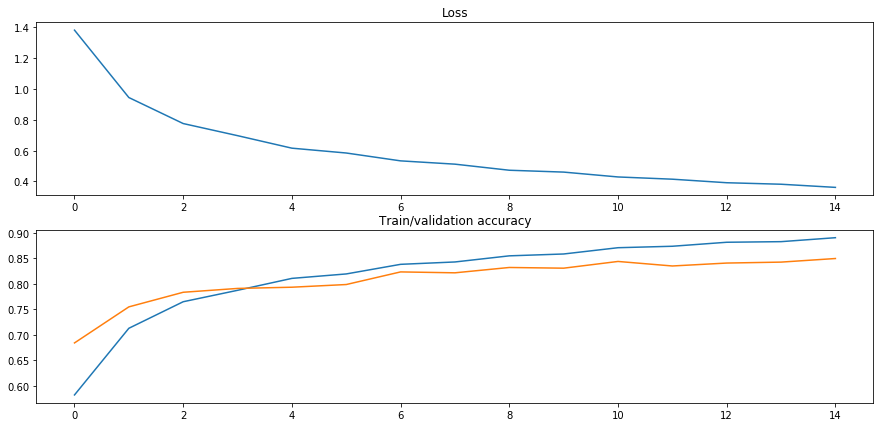

In [65]:
# training with best options for longer period
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(num_input, neuro_num[1]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[1]),
            nn.Linear(neuro_num[1], neuro_num[2]),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(neuro_num[2]),
            nn.Linear(neuro_num[2], num_output), 
)

optimizer = optim.Adam(nn_model.parameters(), lr=best_hp[0])
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 15,\
                                                   scheduler_step=2, lr_decay_factor=best_hp[1])
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

In [67]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=best_hp[2])
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8268
